In [1]:
import pandas as pd
import numpy as np
import os, time, stat, io, glob, pickle
from scipy.stats import gamma, norm
from sklearn.linear_model import LinearRegression
from IPython.core.display import display, HTML

import matplotlib.pyplot as plt
import matplotlib as mpl
plt.style.use('fivethirtyeight')
import plotly.io as pio

%load_ext autoreload
%autoreload 2
from covid_data_helper import *
from coronita_chart_helper import *
from coronita_model_helper import *
from coronita_web_helper import *
from coronita_bokeh_helper import *

from matplotlib.backends.backend_pdf import PdfPages


In [2]:
## DATA INGESTION ##

df_st_testing = get_covid19_tracking_data()

df_census = get_census_pop()

counties_geo = get_counties_geo()

# df_jhu_counties = get_jhu_counties()

df_st_testing_fmt = df_st_testing.copy()
df_st_testing_fmt = df_st_testing_fmt.rename(columns={'death':'deaths','positive':'cases'}).unstack('code')

try:
    df_interventions = get_state_policy_events()
except:
    df_interventions = pd.DataFrame()

df_goog_mob_us = get_goog_mvmt_us()
df_goog_mob_state = get_goog_mvmt_state(df_goog_mob_us)

df_counties = get_complete_county_data(df_census, df_goog_mob_us)

df_hhs_hosp = get_hhs_hosp()

df_can = get_can_data()

df_vax_hes = get_vax_hesitancy_data()


State Testing Data Last Observation:  20210307
Got COVID19 Tracking Data
Got CDC Death Data
Got HHS testing data
Got HHS hospital data.
Got Census Data
Got counties geo json
Got KFF Policy dates
Got Google Movement Data
Got NYS DOH data
Got NYT county level data.
Got NYC DOH data
Got Complete County Time Series Data
Got HHS hospitalization data.
Got COVID Act Now data.
Got Census Data
Got HHS Vaccine Hesitancy Data.


In [12]:
## MODEL PARAMETERS ##

covid_params = {}
covid_params['d_incub'] = 3.
covid_params['d_infect'] = 4.
covid_params['mort_rt'] = 0.01
covid_params['d_in_hosp'] = 11
covid_params['hosp_rt'] = 0.04
covid_params['d_to_hosp'] = 7.0
covid_params['d_in_hosp_mild'] = 11.0
covid_params['icu_rt'] = 13./41.
covid_params['d_in_icu'] = 13.0
covid_params['vent_rt'] = 0.4
covid_params['d_til_death'] =  17.0
covid_params['policy_trigger'] = True
covid_params['policy_trigger_once'] = True
# covid_params['pg_summer_dt'] = '2021-07-04'
days_to_forecast = 150

covid_params['voc_transmissibility'] = 1.5 #1.2
covid_params['eff_vax_half'] = 0.8
covid_params['eff_vax_full'] = 0.9

In [5]:
try:
    list_of_files = glob.glob('./output/df_fore_allstates_*.pkl') # * means all if need specific format then *.csv
    latest_file = max(list_of_files, key=os.path.getctime)
    print('last forecast: ', latest_file)
    df_prevfore_allstates = pd.read_pickle(latest_file)
except:
    if 'df_fore_allstates' in globals().keys():
        if df_fore_allstates.shape[0] > 0:
            df_prevfore_allstates = df_fore_allstates.copy()
            
            
list_of_files = glob.glob('./output/allstate_model_dicts_*.pkl') # * means all if need specific format then *.csv
latest_file = max(list_of_files, key=os.path.getctime)
print(latest_file)
with open(latest_file, 'rb') as handle:
    allstate_model_dicts = pickle.load(handle)


last forecast:  ./output/df_fore_allstates_20210711.pkl
./output/allstate_model_dicts_20210711.pkl


In [6]:
state= 'NY'

model_dict = make_model_dict_state(state, abbrev_us_state, df_census, df_st_testing_fmt, df_hhs_hosp, 
                                   df_can, df_counties, df_vax_hes,
                                       covid_params, days_to_forecast,
                                       df_mvmt=df_goog_mob_state
                                     , df_interventions=df_interventions
                                      )


deaths shifted by:  -20


In [22]:
state= 'NY'

model_dict = make_model_dict_state(state, abbrev_us_state, df_census, df_st_testing_fmt, df_hhs_hosp, 
                                   df_can, df_counties, df_vax_hes,
                                       covid_params, days_to_forecast,
                                       df_mvmt=df_goog_mob_state
                                     , df_interventions=df_interventions
                                      )

try:
    first_guess = df_prevfore_allstates[state].first_valid_index()[0]
except:
    # first_guess = pd.Timestamp('2020-02-17')
    local_r0_date = model_dict['df_rts'].loc['2020-02-01':'2020-04-30', 'weighted_average'].idxmax()
    first_guess = local_r0_date - pd.Timedelta(days=28)

first_guess = pd.Timestamp('2020-02-01')
model_dict = model_find_start(first_guess, model_dict)

deaths shifted by:  -20
This guess:  2020-02-01 00:00:00
This rmse:  283.6537612256184
Change in rmse:  -1
Average Error:  867.6680118717532
This guess:  2020-01-31 00:00:00
This rmse:  364.5423377541192
Change in rmse:  80.88857652850083
Average Error:  -2374.841066546589
Best starting date:  2020-02-01 00:00:00


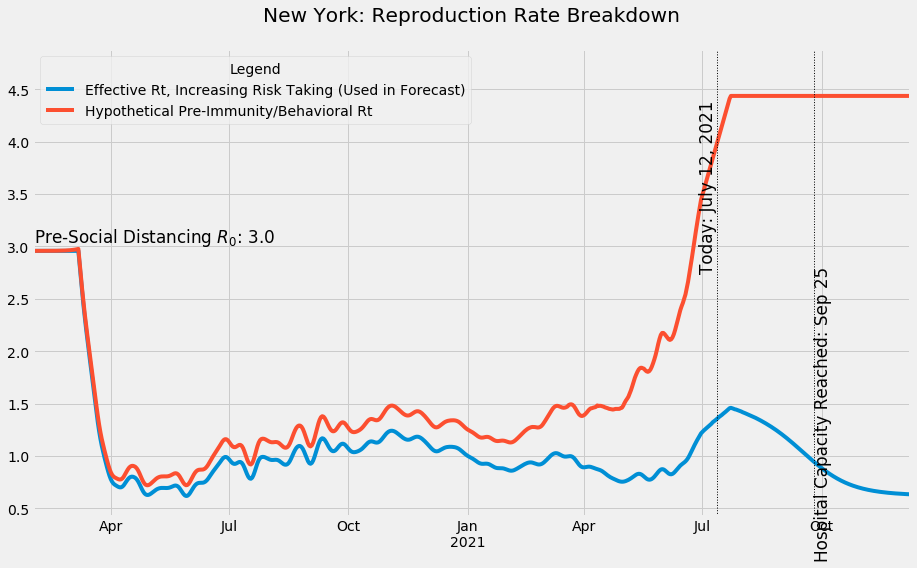

In [23]:
ch_rt_scen_explanation(model_dict)

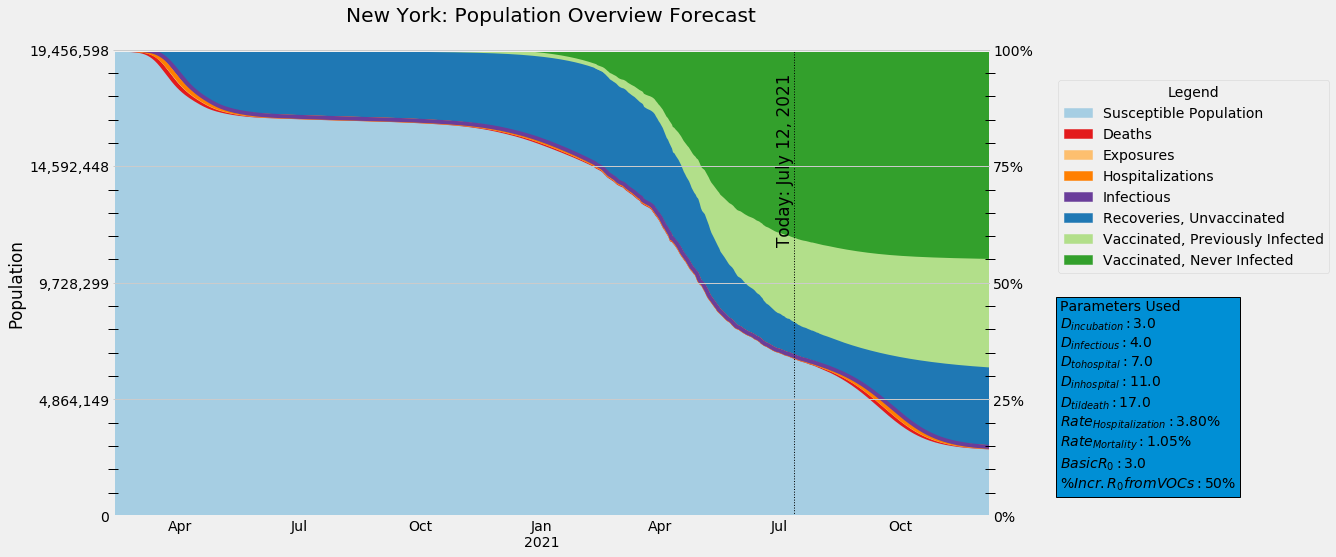

In [29]:
ch_population_share(model_dict)

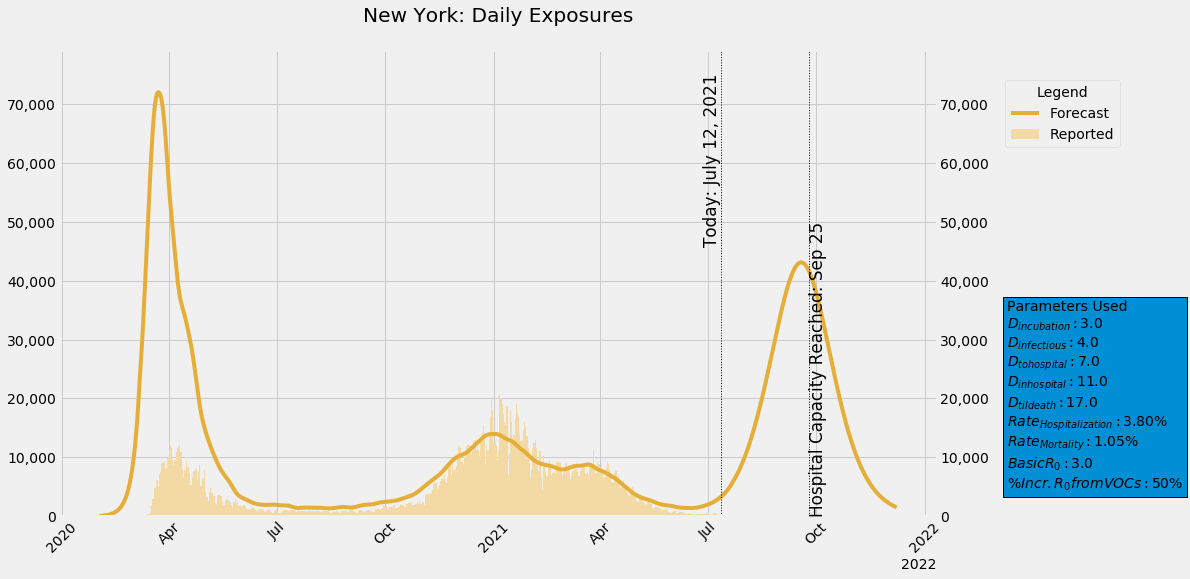

In [30]:
ch_daily_exposures(model_dict)

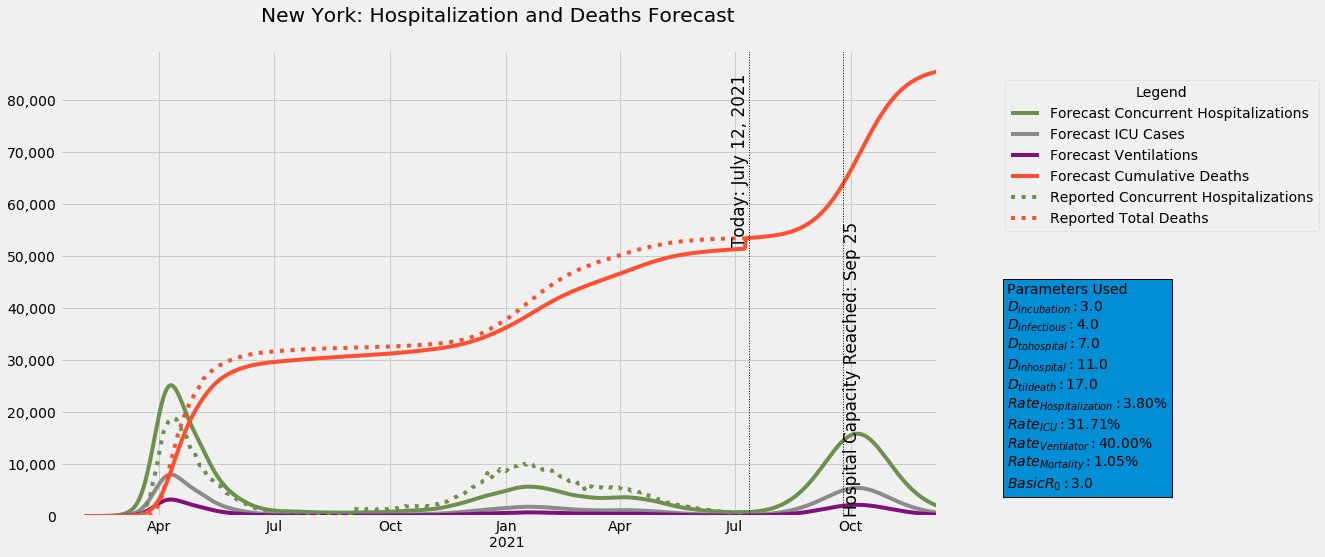

In [25]:
ch_hosp(model_dict)

In [21]:
list_of_files = glob.glob('./output/df_fore_allstates_*.pkl') # * means all if need specific format then *.csv
latest_file = max(list_of_files, key=os.path.getctime)
print(latest_file)
df_fore_allstates = pd.read_pickle(latest_file)

list_of_files = glob.glob('./output/df_wavg_rt_conf_allregs_*.pkl') # * means all if need specific format then *.csv
latest_file = max(list_of_files, key=os.path.getctime)
print(latest_file)
df_wavg_rt_conf_allregs = pd.read_pickle(latest_file)

./output/df_fore_allstates_20210711.pkl
./output/df_wavg_rt_conf_allregs_20210711.pkl


In [50]:
tab_html, df_tab, df_tab_us, df_tab_unfmt = tab_summary(df_st_testing_fmt, df_fore_allstates, df_census, df_wavg_rt_conf_allregs, 
            df_hhs_hosp, allstate_model_dicts)
display(HTML(tab_html))
text_file = open("../COVIDoutlook/forecasts/plotly/summ_tab.html", "w")
text_file.write(tab_html)
text_file.close()


Riskiest State Rank,State,Population,Model Est'd Active Infections per 100k,Current Reproduction Rate (Rt),"Vaccine Hesitant, % of Adults",Daily Vaccines Initiated,"Vaccines Initiated, % of Pop.","Vaccine & Acquired Immunity, % of Pop.",Forecasted Date Herd Immunity Achieved,Days to Hospital Capacity,Total Cases per 100k,14-Day Avg Daily Cases per 100k,Positivity Rate,Total Deaths per 100k,14-Day Avg Daily Deaths per 100k,Hospitalized per 100k,14-Day Avg Daily Hosp Admits per 100k
1,Alaska,"731,545",433,000.850.85 🟢,000000020%20%,"000001,2001,200",000000042%42%,000000048%48%,"210511May 11, 2021",121120+ 🟢,"14,950",00000018.618.6▼,0000003.1%3.1%▶,47,0.0▶,0000007.667.66▶,1.17▲
2,Michigan,"9,986,857",390,000.800.80 🟢,000000019%19%,"000030,26130,261",000000043%43%,000000043%43%,"210721July 21, 2021",121120+ 🟢,"10,232",00000041.141.1▼,0000011.5%11.5%▼,188,0.6▲,0000031.8231.82▼,5.19▼
3,Pennsylvania,"12,801,989",268,000.850.85 🟢,000000015%15%,"000058,00758,007",000000050%50%,000000046%46%,"210703July 03, 2021",121120+ 🟢,"9,297",00000020.720.7▼,0000007.6%7.6%▶,205,0.3▲,0000021.0621.06▲,5.90▼
4,South Dakota,"884,659",250,000.970.97 🟢,000000021%21%,"000001,2791,279",000000045%45%,000000047%47%,"210514May 14, 2021",121120+ 🟢,"7,645",00000012.512.5▼,0000009.7%9.7%▼,222,0.1▶,0000011.7611.76▶,2.73▼
5,Illinois,"12,671,821",212,000.950.95 🟢,000000015%15%,"000045,93645,936",000000047%47%,000000042%42%,"210723July 23, 2021",121120+ 🟢,"10,411",00000015.815.8▼,0000003.9%3.9%▶,192,0.2▶,0000016.1416.14▲,4.50▶
6,Hawaii,"1,415,872",204,001.001.00 ▶,000000010%10%,"000008,3768,376",000000053%53%,000000040%40%,"210518May 18, 2021",121120+ 🟢,"2,651",00000004.94.9▼,0000001.7%1.7%▶,34,0.0▶,0000003.813.81▶,1.27▲
7,West Virginia,"1,792,147",201,000.970.97 🟢,000000020%20%,"000001,7251,725",000000036%36%,000000044%44%,"210618June 18, 2021",121120+ 🟢,"10,388",00000016.816.8▼,0000006.7%6.7%▶,149,-0.4▼,0000014.6814.68▶,5.18▲
8,Delaware,"973,764",200,000.810.81 🟢,000000013%13%,"000003,5763,576",000000047%47%,000000043%43%,"210521May 21, 2021",121120+ 🟢,"12,282",00000017.417.4▼,0000005.6%5.6%▶,167,0.2▼,0000020.3320.33▶,6.26▼
9,Indiana,"6,732,219",193,000.960.96 🟢,000000018%18%,"000016,35516,355",000000036%36%,000000039%39%,"210727July 27, 2021",121120+ 🟢,"12,023",00000010.910.9▼,0000005.1%5.1%▶,198,0.1▶,0000012.8612.86▶,3.22▲
10,Alabama,"4,903,185",190,001.081.08 ▶,000000021%21%,"000007,9417,941",000000033%33%,000000040%40%,"210620June 20, 2021",121120+ 🟢,"10,763",00000006.16.1▶,0000006.7%6.7%▶,222,0.1▶,0000008.998.99▶,3.08▲


In [63]:
from test import *
blue

'hi world'

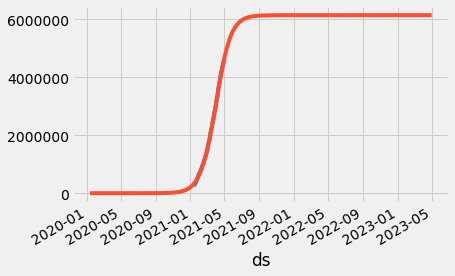

In [69]:
model_dict['df_hist']['vax_initiated'].dropna().interpolate().plot()
model_dict['df_vax_fore']['trend'].plot()

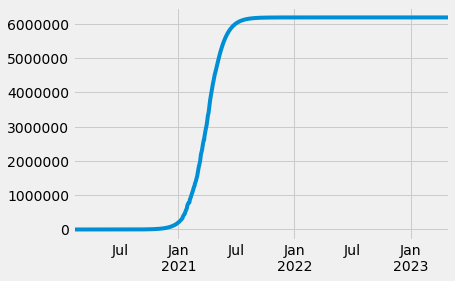

In [72]:
start_dt = '2020-02-04'
vax_new_people_daily = model_dict['df_hist']['vax_initiated'].diff() \
    .reindex(model_dict['df_vax_fore'].index).fillna(model_dict['df_vax_fore']['trend'].diff())
vax_new_people_daily = vax_new_people_daily.reindex(index=pd.date_range(start_dt, vax_new_people_daily.index[-1]))
vax_new_people_daily = vax_new_people_daily.fillna(method='bfill')
vax_new_people_daily.cumsum().plot()

In [252]:
from ode_vax_test import *
start_dt = pd.Timestamp('2020-02-01')
model_dict = allstate_model_dicts['NJ']
model_dict['covid_params']['pg_summer_dt'] = '2021-07-04'
exposed_0 = 100
infectious_0 = 0

# def seir_model_cohort(start_dt, model_dict, exposed_0=100, infectious_0=100):

vax_new_people_daily = model_dict['df_hist']['vax_initiated'].diff() \
    .reindex(model_dict['df_vax_fore'].index).fillna(model_dict['df_vax_fore']['trend'].diff())
vax_new_people_daily = vax_new_people_daily.reindex(index=pd.date_range(start_dt, vax_new_people_daily.index[-1]))
vax_new_people_daily = vax_new_people_daily.fillna(method='bfill')

V_Sus_0 = model_dict['df_vax_fore']['trend'].loc[start_dt] \
    if start_dt in model_dict['df_vax_fore']['trend'].index else 0

## Initial Conditions ##
N = model_dict['tot_pop']
E = [exposed_0]
E_new = [exposed_0]
I_Mild = [infectious_0]
I_Sev = [infectious_0]
I_Fatal = [infectious_0]
H_Sev = [0]
H_Fatal = [0]
H_Admits = [0]
R = [0]
D = [0]
V_Sus = [V_Sus_0]
V_Rec = [0]
S = [N - E[-1] - V_Sus[-1]]
level_lists = [S, E, E_new, I_Mild, I_Sev, I_Fatal, H_Sev, H_Fatal, H_Admits, R, D, V_Sus, V_Rec]

t = np.linspace(0, model_dict['d_to_forecast'], model_dict['d_to_forecast'] + 1)

r_t_dts = pd.date_range(start_dt,
                        max(start_dt + pd.Timedelta(days=model_dict['d_to_forecast']),
                            pd.Timestamp(model_dict['covid_params']['pg_summer_dt']) ) )
r_t = pd.Series(np.nan, index=r_t_dts)
if 'rt_scenario' in model_dict['df_rts'].columns:
    r_t = r_t.fillna(model_dict['df_rts']['rt_scenario']).fillna(method='bfill').fillna(method='ffill')
else:
    local_r0_date = model_dict['df_rts'].loc['2020-02-01':'2020-04-30', 'weighted_average'].idxmax()
    # print('local_r0_date: ', local_r0_date)
    r_t = r_t.fillna(model_dict['df_rts'].loc[local_r0_date:, 'weighted_average'])
    r_t = r_t.fillna(method='bfill').fillna(method='ffill')
r_t_preimmune = r_t.copy()
last_r = r_t.iloc[0]
last_obs_rt = model_dict['df_rts']['weighted_average'].last_valid_index()
l_rts = [r_t, r_t_nochange, r_t_preimmune, last_r, last_obs_rt]

model_dict['df_rts'] = model_dict['df_rts'].reindex(r_t.index)
model_dict['df_rts']['policy_triggered'] = 0
model_dict['hosp_cap_dt'] = None

for t_ in t[:-1]:
    model_dict, model_diffs, l_rts = vax_diff_model(
        t_, start_dt, model_dict, level_lists, l_rts, vax_new_people_daily)
    
    level_lists = append_model_diffs(model_diffs, level_lists)


df_agg = pd.DataFrame(level_lists).T
df_agg.index = pd.date_range(
        start_dt - pd.Timedelta(days=1),
        start_dt + pd.Timedelta(days=model_dict['d_to_forecast'] - 1))
df_agg.columns = ['susceptible', 'exposed', 'exposed_daily',
                  'I_Mild', 'I_Sev', 'I_Fatal', 
                  'H_Sev', 'H_Fatal', 'hosp_admits', 
                   'recovered_unvaccinated', 'deaths',
                  'vaccinated_never_infected', 'vaccinated_prev_infected',
       ]
df_agg['recovered'] = df_agg[['recovered_unvaccinated', 'vaccinated_prev_infected']].sum(axis=1)
df_agg['infectious'] = df_agg[['I_Mild', 'I_Sev', 'I_Fatal']].sum(axis=1)
df_agg['hospitalized'] = df_agg[['H_Sev', 'H_Fatal']].sum(axis=1)
df_agg['icu'] = np.nan
df_agg['vent'] = np.nan
df_agg['deaths_daily'] = df_agg['deaths'].diff()


In [253]:
df_agg

,susceptible,exposed,exposed_daily,I_Mild,I_Sev,I_Fatal,H_Sev,H_Fatal,hosp_admits,recovered_unvaccinated,deaths,vaccinated_never_infected,vaccinated_prev_infected,recovered,infectious,hospitalized,icu,vent,deaths_daily
2020-01-31,8.882089e+06,100.000000,100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.153514e-01,0.000000e+00,0.000000e+00,0.000000,0.000000,NaN,NaN,NaN
2020-02-01,8.882089e+06,66.666667,0.000000,32.010539,0.489461,0.833333,0.000000,0.000000,0.000000,0.000000,0.000000,7.153514e-01,7.153514e-01,7.153514e-01,33.333333,0.000000,NaN,NaN,0.000000
2020-02-02,8.882065e+06,68.896267,24.451822,45.348263,0.745846,1.269841,0.069923,0.119048,0.188971,8.002635,0.000000,7.153514e-01,7.153514e-01,8.717986e+00,47.363950,0.188971,NaN,NaN,0.000000
2020-02-03,8.882030e+06,80.674892,34.744047,56.065264,0.976517,1.662571,0.170116,0.296485,0.287955,19.346057,0.003968,7.153514e-01,7.153514e-01,2.006141e+01,58.704351,0.466601,NaN,NaN,0.003968
2020-02-04,8.881987e+06,96.846112,43.062851,67.873415,1.231887,2.097352,0.294153,0.524113,0.377013,33.377838,0.013851,7.153514e-01,7.153514e-01,3.409319e+01,71.202654,0.818266,NaN,NaN,0.009883
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-28,2.069339e+06,71.825338,21.848115,110.412132,6.993882,2.381490,19.576650,67.367309,1.397288,668000.438609,29227.428712,4.866919e+06,4.867107e+06,5.535107e+06,119.787503,86.943958,NaN,NaN,2.310772
2021-09-29,2.068758e+06,68.814292,20.930733,105.800776,6.703517,2.282618,18.796080,65.461944,1.339339,667848.776245,29229.674289,4.867480e+06,4.867661e+06,5.535510e+06,114.786911,84.258025,NaN,NaN,2.245577
2021-09-30,2.068197e+06,65.927525,20.051330,101.378408,6.424920,2.187752,18.044991,63.605968,1.283733,667702.515221,29231.856354,4.868020e+06,4.868194e+06,5.535897e+06,109.991080,81.650959,NaN,NaN,2.182065
2021-10-01,2.067658e+06,63.160059,19.208376,97.137562,6.157637,2.096740,17.322383,61.798305,1.230382,667561.464780,29233.976553,4.868541e+06,4.868709e+06,5.536270e+06,105.391938,79.120688,NaN,NaN,2.120199


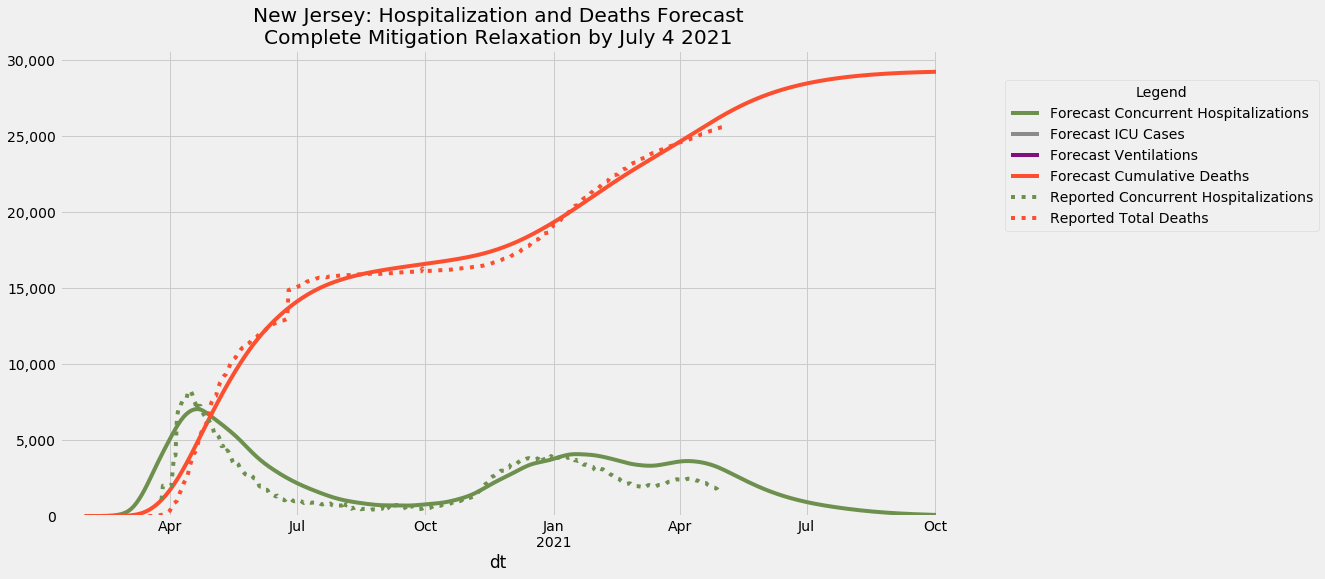

In [254]:
df_chart = df_agg[['hospitalized', 'icu', 'vent', 'deaths']].dropna(how='all').copy()
df_chart = df_chart.rename(columns={'hospitalized':'Forecast Concurrent Hospitalizations',
                                    'icu':'Forecast ICU Cases',
                                    'vent':'Forecast Ventilations',
                                    'deaths':'Forecast Cumulative Deaths'})

ax = df_chart.plot(figsize=[14, 8],
                   title=model_dict['region_name']+': Hospitalization and Deaths Forecast\n'+model_dict['chart_title'],
                   color=['#6d904f', '#8b8b8b', '#810f7c', '#fc4f30'],
                   label=['Forecast Concurrent Hospitalizations',
                          'Forecast ICU Cases',
                          'Forecast Ventilations',
                          'Forecast Cumulative Deaths'])
_ = ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
if 'hosp_concur' in model_dict['df_hist'].columns:
    model_dict['df_hist']['hosp_concur'].plot(ax=ax, linestyle=':', legend=True,
                                              label='Reported Concurrent Hospitalizations',
                                              color=['#6d904f'])
if 'deaths_tot' in model_dict['df_hist'].columns:
    model_dict['df_hist']['deaths_tot'].loc[
    df_chart.index[0]:].plot(ax=ax, linestyle=':', legend=True,
                             label='Reported Total Deaths',
                             color='#fc4f30')
ax.set_ylim([0, ax.get_ylim()[1]])
plt.legend(title='Legend', loc='upper left', bbox_to_anchor=(1.07, 0.95), ncol=1)

In [11]:
# ch_statemap_casechange(model_dict, counties_geo)

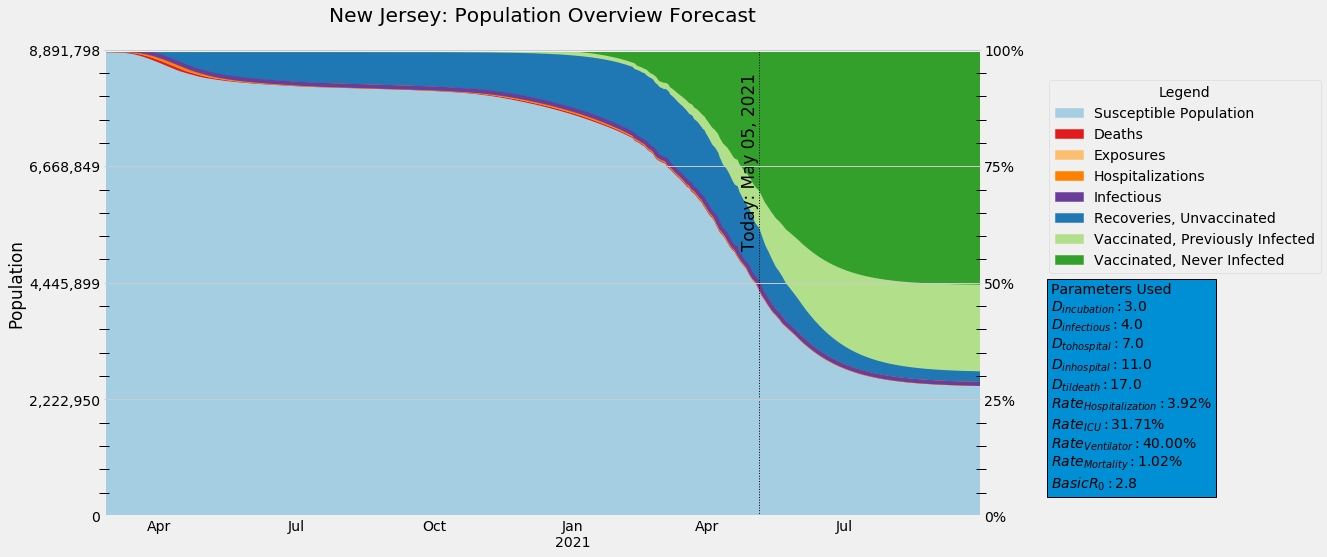

In [51]:
ch_population_share(model_dict)

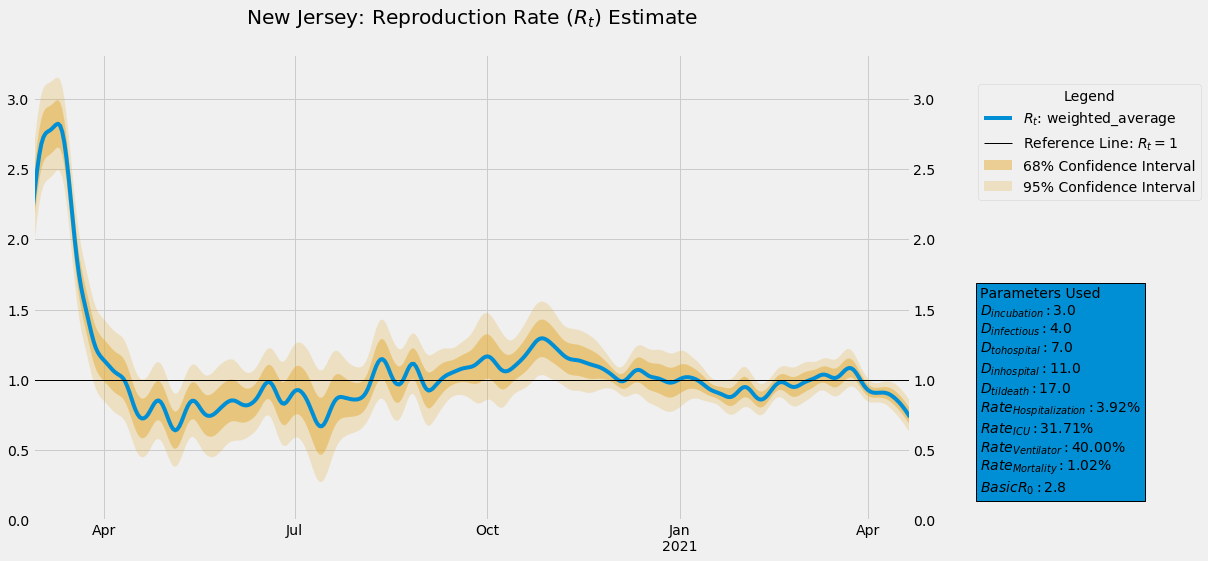

In [13]:
ch_rt_confid(model_dict)

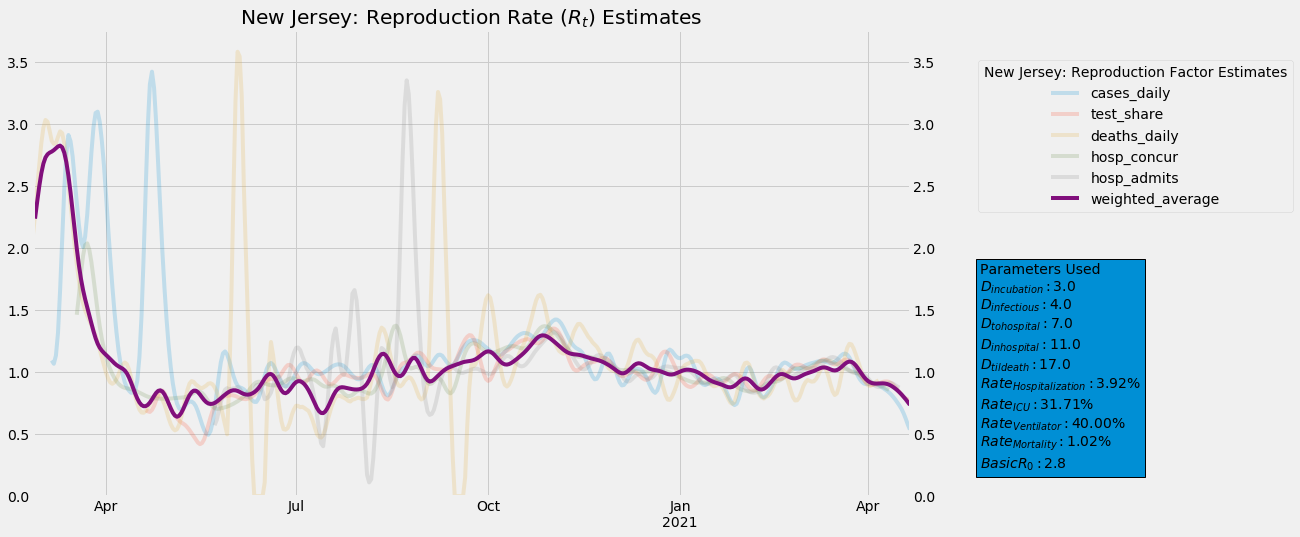

In [14]:
ch_rts(model_dict)

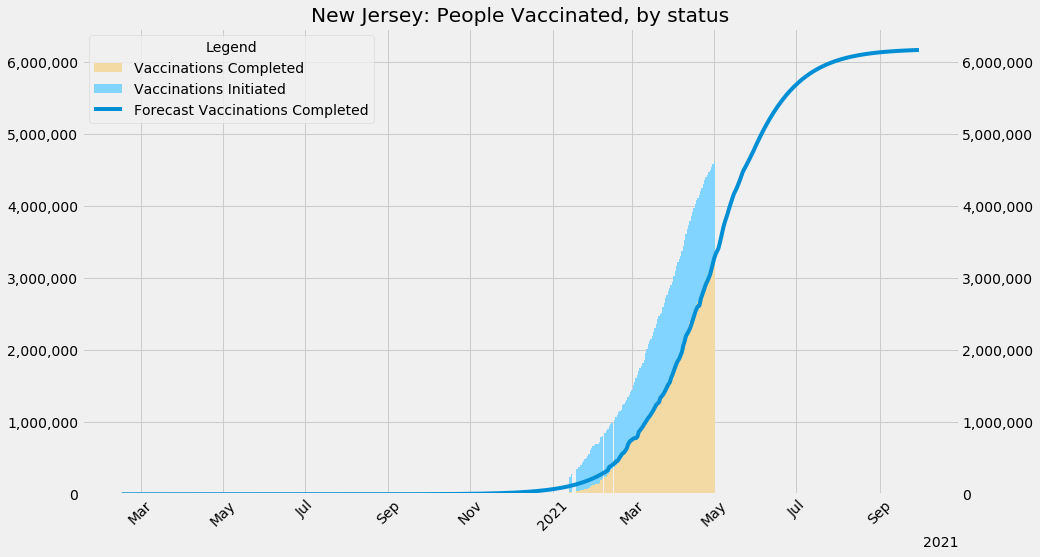

In [15]:
ch_vax_status(model_dict)

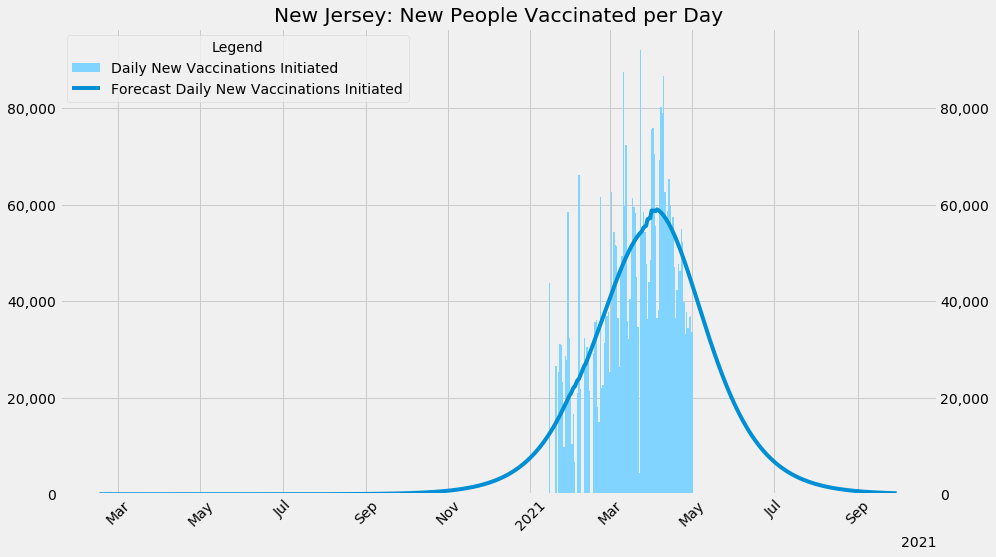

In [16]:
ch_vax_daily(model_dict)

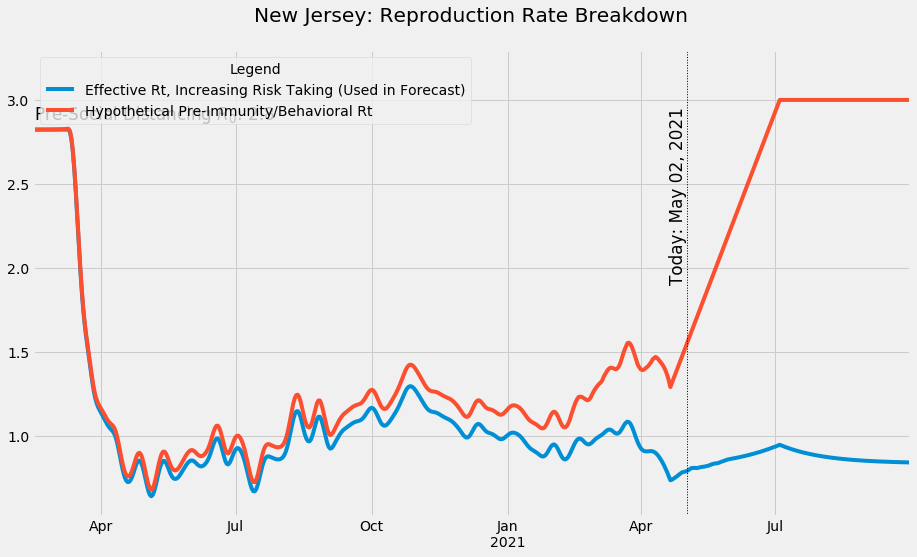

In [17]:
ch_rt_scen_explanation(model_dict)

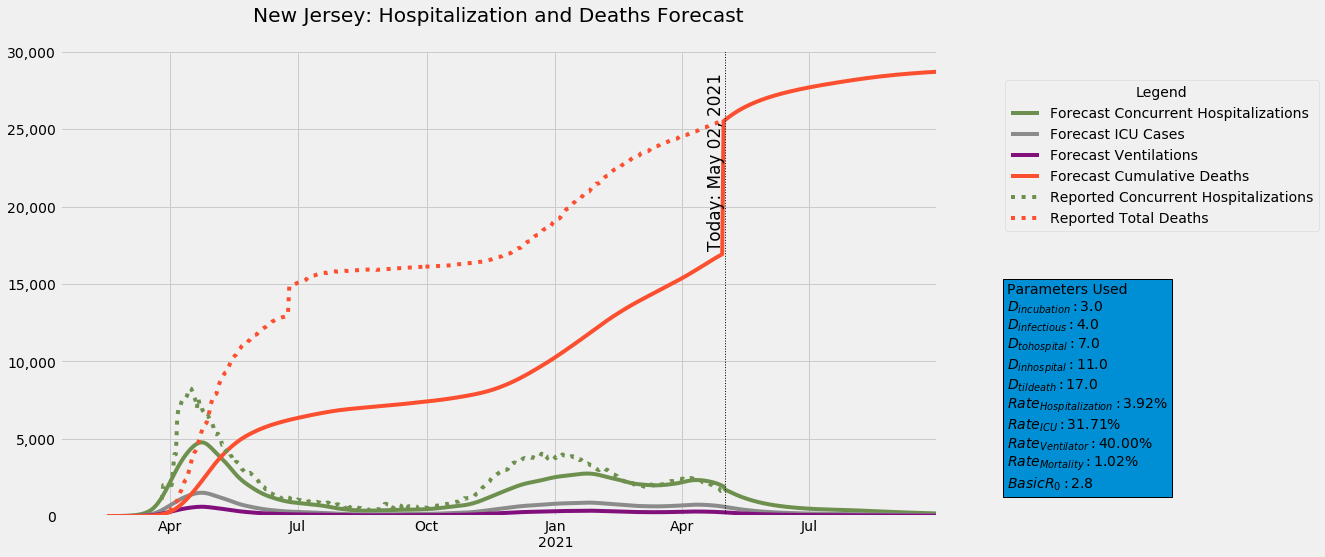

In [18]:
ch_hosp(model_dict)

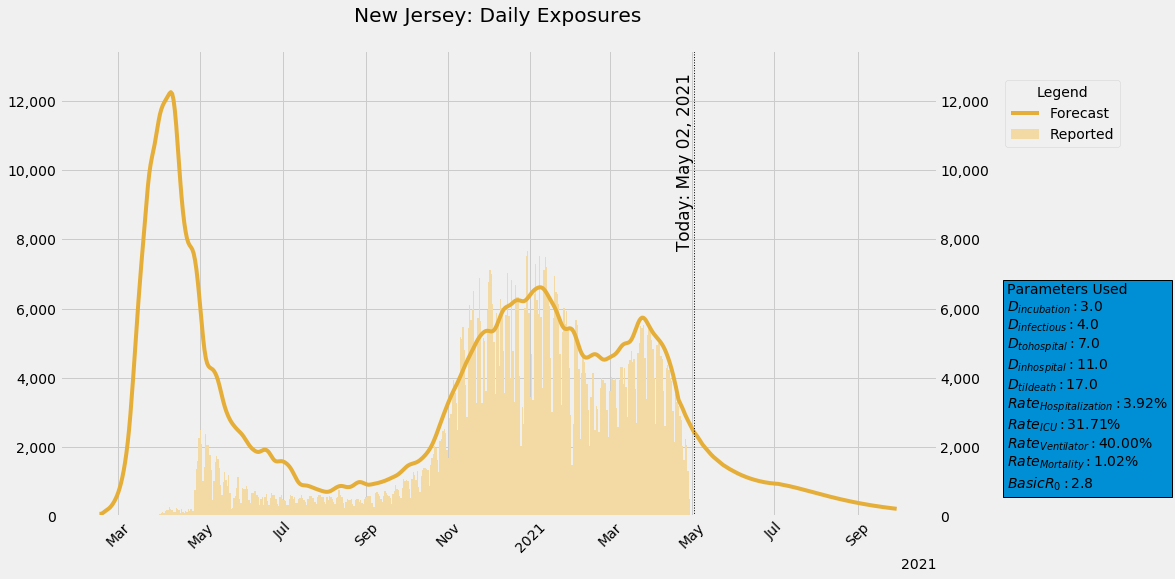

In [19]:
ch_daily_exposures(model_dict)

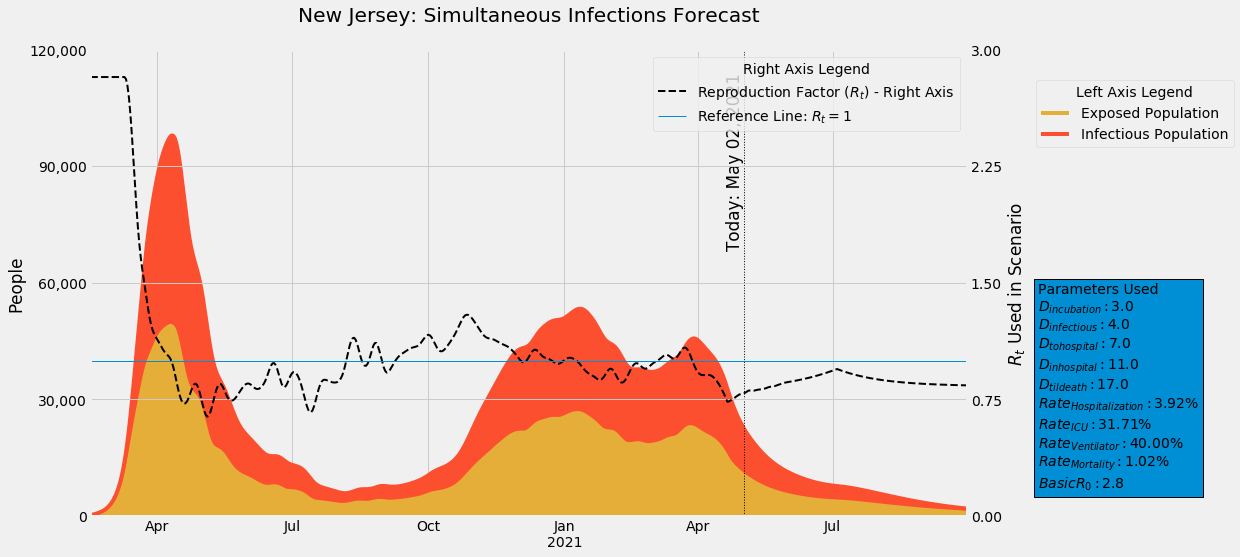

In [20]:
ch_exposed_infectious(model_dict)

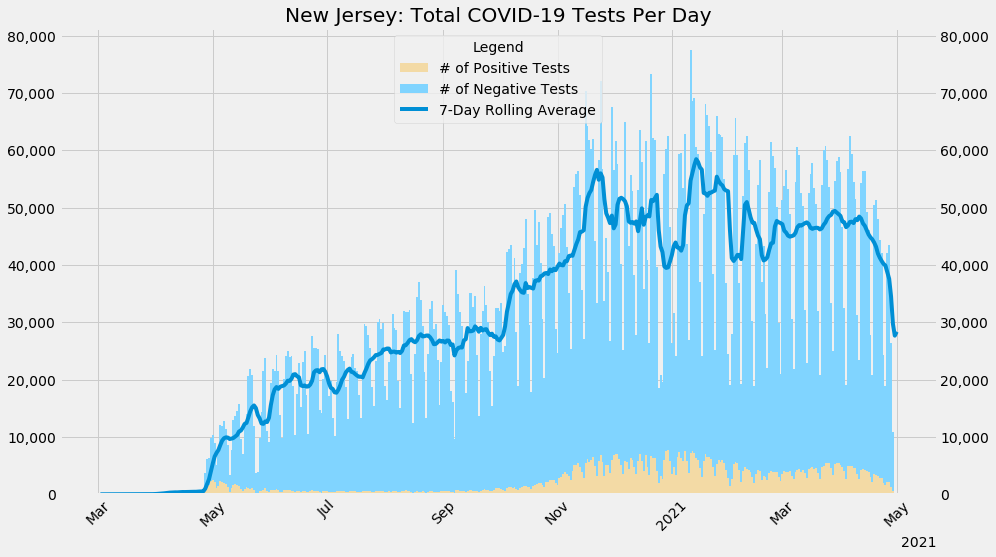

In [21]:
ch_totaltests(model_dict)

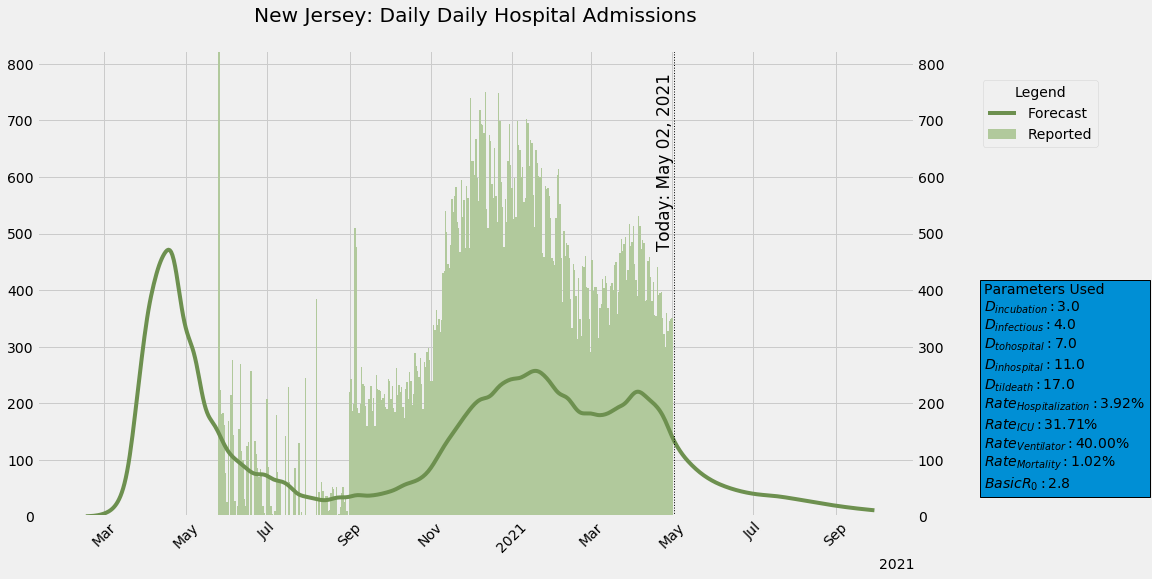

In [22]:
ch_hosp_admits(model_dict)

In [ ]:
# model_dict= allstate_model_dicts['US']

# reset_output()
# output_notebook()
# p = bk_population_share(model_dict)
# show(bk_overview_layout(p))
